# Importing Dependencies

In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    Dense,
    GlobalAveragePooling2D,
    Dropout,
    InputLayer,
    Flatten
)
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import ResNet50

# Scikit-learn
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_curve
)

# Visualization
import seaborn as sns

# Fetching the Dataset

In [10]:
# Set path to the main dataset directory
dataset_dir = '/kaggle/input/freshwater-fish-disease-aquaculture-in-south-asia/Freshwater Fish Disease Aquaculture in south asia/Train'

# Parameters
IMAGE_SIZE = 224
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2
SEED = 123

# Load training dataset
train_ds = image_dataset_from_directory(
    dataset_dir,
    validation_split=VALIDATION_SPLIT,
    subset="training",
    seed=SEED,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

# Load validation dataset
val_ds = image_dataset_from_directory(
    dataset_dir,
    validation_split=VALIDATION_SPLIT,
    subset="validation",
    seed=SEED,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

# Retrieve class names
class_names = train_ds.class_names
print("Class names:", class_names)

Found 1747 files belonging to 7 classes.
Using 1398 files for training.
Found 1747 files belonging to 7 classes.
Using 349 files for validation.
Class names: ['Bacterial Red disease', 'Bacterial diseases - Aeromoniasis', 'Bacterial gill disease', 'Fungal diseases Saprolegniasis', 'Healthy Fish', 'Parasitic diseases', 'Viral diseases White tail disease']


In [11]:
class_names = train_ds.class_names
class_names

['Bacterial Red disease',
 'Bacterial diseases - Aeromoniasis',
 'Bacterial gill disease',
 'Fungal diseases Saprolegniasis',
 'Healthy Fish',
 'Parasitic diseases',
 'Viral diseases White tail disease']

# Visualizing the first batch of images.

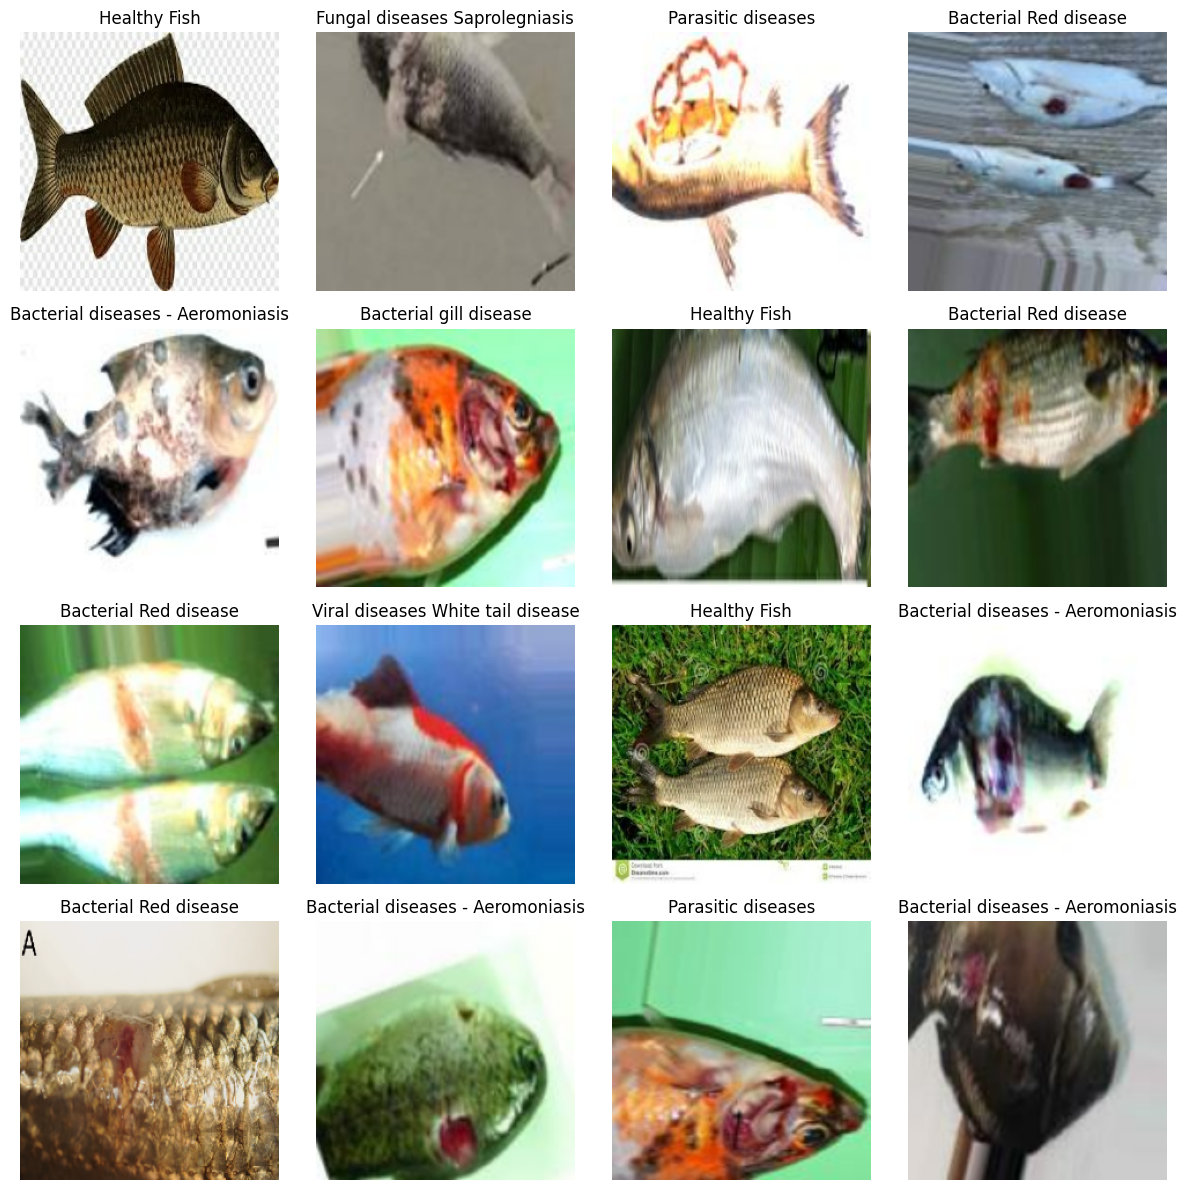

In [13]:
plt.figure(figsize=(12, 12))
for batch_images, batch_labels in train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(batch_images[i].numpy().astype("uint8"))
        plt.title(class_names[batch_labels[i].numpy()])
        plt.axis("off")
plt.tight_layout()


# Splitting Dataset into Training, Validation, and Testing

In [14]:
VALIDATION_SPLIT = 0.1

In [15]:
train_ds = image_dataset_from_directory(
    dataset_dir,
    validation_split=VALIDATION_SPLIT,
    subset="training",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

val_ds = image_dataset_from_directory(
    dataset_dir,
    validation_split=VALIDATION_SPLIT,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)


Found 1747 files belonging to 7 classes.
Using 1573 files for training.
Found 1747 files belonging to 7 classes.
Using 174 files for validation.


# Building Model

## Resizing and Normalization Layer

In [16]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

## Data Augmentation

In [17]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.1),
])

## Applying Data Augmentation to Train Dataset

In [18]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

## Model Architecture

In [19]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)  # Make sure CHANNELS = 3 for RGB
n_classes = len(class_names)

# Load pre-trained ResNet50 without the top classification layers
base_model = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape
)
base_model.trainable = False  # Freeze the base model

# Build the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Better than Flatten() for pretrained models
    layers.Dense(384, activation='relu'),
    layers.Dropout(0.3),  # Optional: helps prevent overfitting
    layers.Dense(n_classes, activation='softmax')
])


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [20]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

### Creating a checkpoint to save the model with the best score.

In [21]:
callback = [
    tf.keras.callbacks.ModelCheckpoint(filepath='model.keras')
]

## Training

In [24]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping
callback = [EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)]

# 1️⃣ Initial training (feature extraction)
EPOCHS = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
    callbacks=callback
)

# 2️⃣ Fine-tuning (unfreeze base model & train with lower LR)
base_model.trainable = True  # Unfreeze ResNet50

# Re-compile with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Continue training
FINE_TUNE_EPOCHS = 5
history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    verbose=1,
    epochs=FINE_TUNE_EPOCHS,
    callbacks=callback
)


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 51s 736ms/step - accuracy: 0.3594 - loss: 2.1042 - val_accuracy: 0.7011 - val_loss: 0.9050
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 62s 491ms/step - accuracy: 0.6787 - loss: 0.9243 - val_accuracy: 0.7184 - val_loss: 0.7586
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 420ms/step - accuracy: 0.7257 - loss: 0.7565 - val_accuracy: 0.7471 - val_loss: 0.7139
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 40s 410ms/step - accuracy: 0.7896 - loss: 0.6364 - val_accuracy: 0.8333 - val_loss: 0.5706
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 423ms/step - accuracy: 0.8302 - loss: 0.4902 - val_accuracy: 0.8333 - val_loss: 0.4948
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 424ms/step - accuracy: 0.8542 - loss: 0.4157 - val_accuracy: 0.8506 - val_loss: 0.4794
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 422ms/step - accuracy: 0.8558 - loss: 0.3803 - val_accuracy: 0.8736 - val_loss: 0.4144
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 414ms/step - accuracy: 0.8662 - loss: 0.4038 - val_accu

In [27]:
model.save('model.keras')

##### Download it to local machine (Optional)

In [25]:
# model.save('fish_disease_model.h5')
# from google.colab import files
# files.download('fish_disease_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Loading Model

In [28]:
model = load_model('model.keras')

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 218 variables whereas the saved optimizer has 434 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## Evaluation

In [34]:
PATH = '/kaggle/input/freshwater-fish-disease-aquaculture-in-south-asia/Freshwater Fish Disease Aquaculture in south asia/Test'

test_dataset = image_dataset_from_directory(
    PATH,
    seed=42,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
).prefetch(buffer_size=tf.data.AUTOTUNE)


Found 697 files belonging to 7 classes.


### Predict

In [35]:
all_predictions = []
all_labels = []
for images, labels in test_dataset:
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    all_predictions.extend(predicted_classes)
    all_labels.extend(labels.numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


### Metrices

In [37]:
accuracy = accuracy_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
precision = precision_score(all_labels, all_predictions, average='weighted')

print("Accuracy: ", accuracy)
print("F1 Score: ", f1)
print("Recall: ", recall)
print("Precision: ", precision)

Accuracy:  0.9526542324246772
F1 Score:  0.952456839182877
Recall:  0.9526542324246772
Precision:  0.9536489607507087


### Confusion Matrix

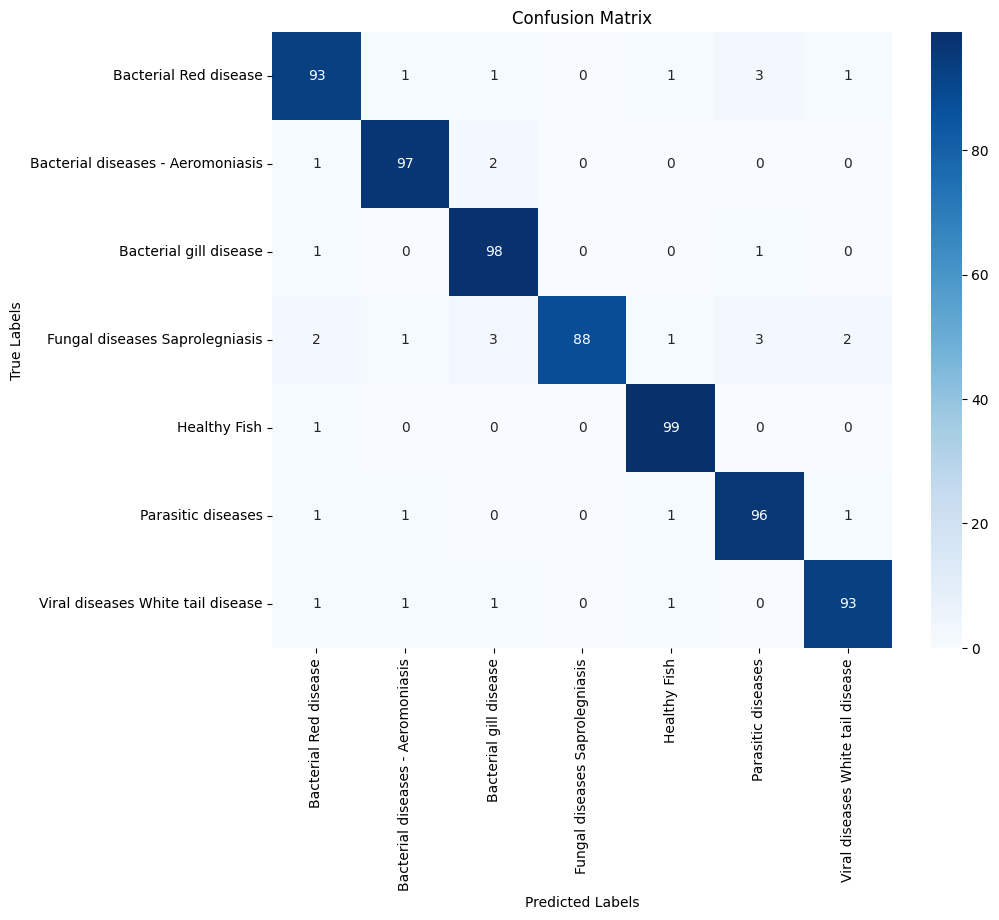

In [38]:
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.savefig('Confusion Matrix.png', dpi = 300)
plt.show()


# Plotting the Accuracy and Loss Curves

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

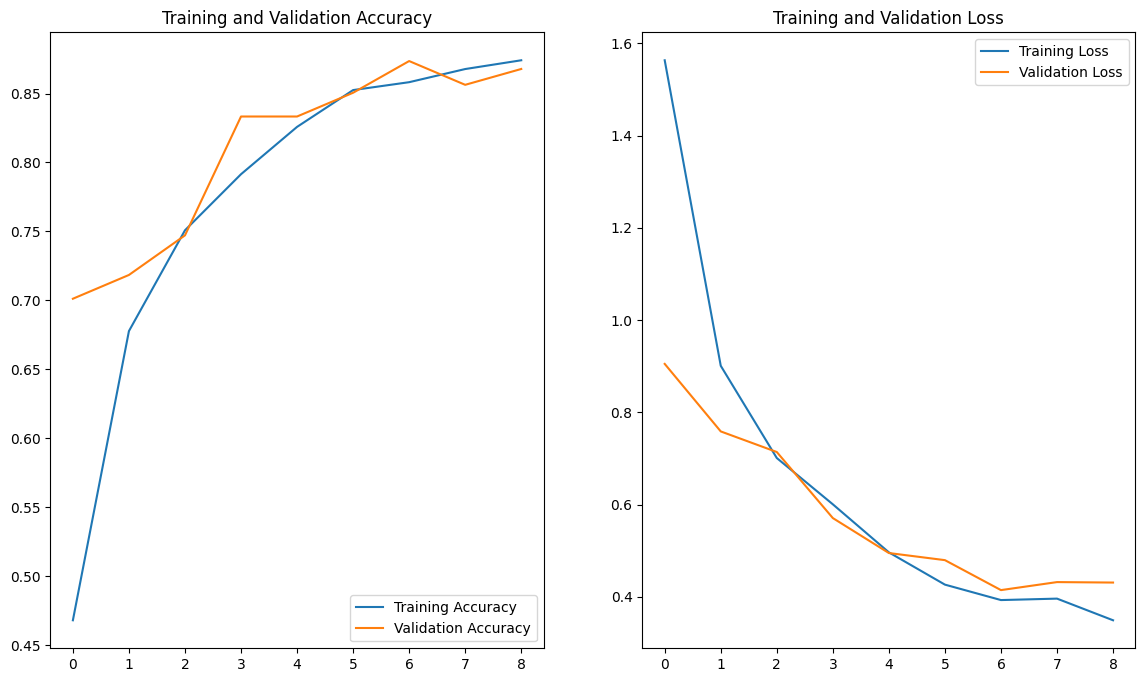

In [43]:
# Plot
plt.figure(figsize=(14, 8))

plt.subplot(1, 2, 1)
plt.plot(range(len(acc)), acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(len(loss)), loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.savefig('curves.png', dpi=300)
plt.show()


# Inference



## Inference Function

In [44]:
def predict(model, image):
    img_array = tf.keras.preprocessing.image.img_to_array(image.numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

## Running Inference

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


<Figure size 640x480 with 0 Axes>

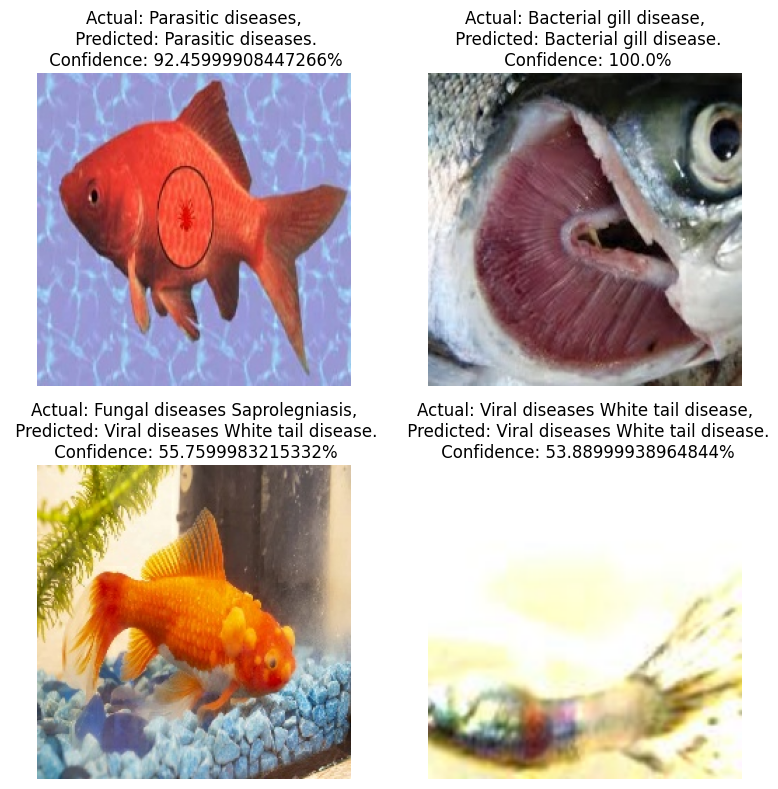

In [45]:
plt.clf()
plt.figure(figsize=(8, 8))
for images, labels in test_dataset.take(6):
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        if i < len(images):
            ax.imshow(images[i].numpy().astype("uint8"))

            predicted_class, confidence = predict(model, images[i])
            actual_class = class_names[labels[i]]

            ax.set_title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
            ax.axis("off")
plt.tight_layout()
plt.show()


# Inference from File

In [59]:
def sample_predict(model, image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(256, 256))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    predicted_class = class_names[predicted_class_index]
    img = Image.open(image_path)
    plt.imshow(img)
    print("Predicted class:", predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
Predicted class: Bacterial gill disease


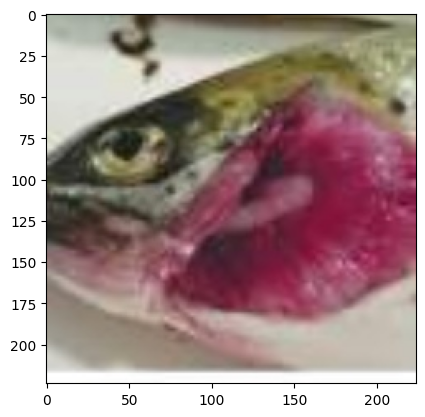

In [60]:
sample_predict(model, '/kaggle/input/freshwater-fish-disease-aquaculture-in-south-asia/Freshwater Fish Disease Aquaculture in south asia/Test/Bacterial gill disease/Bacterial gill disease (1).jpeg')